In [1]:
import os
model_path = './snapshots/EfficientNetB0_csv_29_1.861.h5'
os.path.exists(model_path)

True

In [4]:
import sys 
sys.path.append('keras-retinanet')

import numpy as np
import pandas as pd
import cv2 
import matplotlib.pyplot as plt

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

import efficientnet.tfkeras as efn
# efn.preprocess_input(inputs)

In [3]:
model = models.load_model(model_path , backbone_name='EfficientNetB0')
model = models.convert_model(model)

In [5]:
labels_to_names = pd.read_csv('../data/vehicle-number-plate-detection/classes.csv',  header=None).T.loc[0].to_dict()
labels_to_names

{0: 'license_plate'}

In [6]:
def predict(image):
#     image = preprocess_image(image.copy())
    image = efn.preprocess_input(image.copy())
    image, scale = resize_image(image)
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    boxes /= scale
    return boxes, scores, labels

In [7]:
THRES_SCORE = 0.5
def draw_detections(image, boxes, scores, labels):
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < THRES_SCORE:
            break

        color = label_color(label)
        b = box.astype(int)
        draw_box(image, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(image, b, caption)

In [8]:
def show_detected_objects(data_root_path, image_row):
    img_path = image_row.image_name

    image = read_image_bgr(os.path.join(data_root_path, img_path))

    boxes, scores, labels = predict(image)
    boxes = boxes.numpy()
    scores = scores.numpy()
    labels = labels.numpy()

    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    true_box = [image_row.top_x, image_row.top_y, image_row.bottom_x, image_row.bottom_y]
    draw_box(draw, true_box, color=(255, 255, 0))
    draw_detections(draw, boxes, scores, labels)
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [9]:
test_df = pd.read_csv('../data/vehicle-number-plate-detection/val-annotations.csv', names=['image_name', 'top_x', 'top_y', 'bottom_x', 'bottom_y', 'class_name'])
test_df.head(1)
# for _, row in test_df.iterrows():
#     show_detected_objects(row)

,image_name,top_x,top_y,bottom_x,bottom_y,class_name
0,number_plates/licensed_car_115.jpeg,48,74,599,188,license_plate


(1, 300, 4)
color [31, 0, 255]


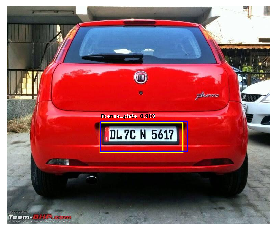

In [10]:
data_root_path = '../data/vehicle-number-plate-detection'
show_detected_objects(data_root_path, test_df.iloc[1])